In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Гауссовские процессы

Вы, наверняка, встрчеали раньше в курсах по машинному обучению такую модель, как гауссовские процессы. Это очень гибкая и мощная модель, несмотря на свою внешнюю простоту.

Гауссовский процесс -- это случайный процесс $(X_t)_{t \in \mathbb{R}}$ такой, что любой вектор $X_{t_1},..,X_{t_k}$, состоящий из набора сечений этого процесса будет иметь гауссовское распределение. Для простоты ограничим себя конкретным случаем: индексное пространство $T = \mathbb{R}$, и процесс принимает значения в $\Xi = \mathbb{R}$. Для того, чтобы построить такой процесс нам нужно задать
1. Матожидание $m:\mathbb{R} \to \mathbb{R}$;
2. Ковариационную функцию $K: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$.
Первый параметр задаёт матожидание для любого вектора сечений, а второй -- ковариационную матрицу.

Существование такого процесса легко проверить с помощью теоремы Колмогорова о существовании(см. доску).

Важный вопрос состоит в том, как именно задавать ковариационную матрицу. 

**Определение.** Функцию $K: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ назовём положительно полуопределённой, если для любого набора $t_1,..,t_k \in T$ матрица $B=(K(t_i,t_j))_{i,j=1,..,k}$ положительно определена, то есть,
$$
\forall x \neq 0 \in \mathbb{R}^k  \quad x^\top B x \geq 0.
$$


**Утверждение.** Функция $K: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ является ковариационной функцией некоторого процесса тогда и только тогда, когда она является симметричной ($K(t,s)=K(s,t)$) и положительно полуопределённой.
**Док-во** на доске.

Первая простая функция с такими свойствами -- это 
$$
K(t,s)= \begin{cases} &\sigma^2, &t=s,\\
&0,&t\neq s
\end{cases}
$$
с некоторым параметром $\sigma \in \mathbb{R}$. Если задать матожидание $m(t)=0$ (любой константе), то мы получим гауссовский белый шум.


## Имплементация

В более общем случае мы хотели бы иметь модель гауссовского процесса для произвольной ковариационной функции (предположим, что пользователь всегда задаёт симметричную и положительно полуопределённую) и произвольной функции матожидания $m(t)$.

In [2]:
class GaussianProcess:
    '''
        General class for Gaussian Processes taking values in R and indexed by R
    '''

    def __init__(self, mu, covFun):
        '''
            Input:
            functionHandler mu -- function mu(t) mapping R --> R, expected value
                must return vector if t is a vector (broadcasting-friendly)
            functionHandler covFun -- function covFun(t,s) mapping R x R --> R, covariance function, symmetric and positive-semidefinite
                must return matrix when arguments are vectors (broadcasting-friendly)
        '''
        self.mu = mu
        self.covFun = covFun

    def sampleTrajectories(self, ts=np.arange(0,1,1/20), nSamples=5):
        '''
            Samples nSamples trajectories of the gaussian process
            Input
            float[] ts -- index array (N,)
            int nSamples -- number of sample trajectories to generate
        '''
        return np.random.multivariate_normal(self.mu(ts),self.covFun(ts,ts),size=nSamples)

In [31]:
def PlotGaussianProcess(gpInstance,nSamples=5,ts=np.arange(0,1,1/20),ax=None,title="Trajectories of Gaussian Process"):
    '''
    Plots nSamples trajectories on a chart
    Input
    GaussianProcess gpInstance -- GaussianProcess object to sample from
    int nSamples -- number of trajectories to generate
    float[] ts -- indices (N,)

    '''
    
    uncertainty = 1.96 * np.sqrt(np.diag(gpInstance.covFun(ts,ts)))
    mu = gpInstance.mu(ts)

    if(ax is None):
        f,ax = plt.subplots(figsize=(7,7))

    ax.grid()
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("T",fontsize=14)
    ax.fill_between(ts, mu + uncertainty, mu - uncertainty, alpha=0.2)
    ax.plot(ts, mu, label='Mean')

    samples = gpInstance.sampleTrajectories(ts,nSamples)

    ax.plot(ts, samples.T, linestyle='--') #transpose to satisfy matplotlib
    
    ax.legend()

    if(ax is None):
        return f,ax
    else:
        return ax

In [32]:
sigma=0.1
def muWhNoise(t):
    return 0*np.ones(t.shape) 
def covWhNoise(t,s):
    return sigma**2 * np.diag(np.ones(t.shape))

gpWhiteNoise = GaussianProcess(muWhNoise,covWhNoise)

<AxesSubplot:title={'center':'Trajectories of Gaussian Process'}, xlabel='T'>

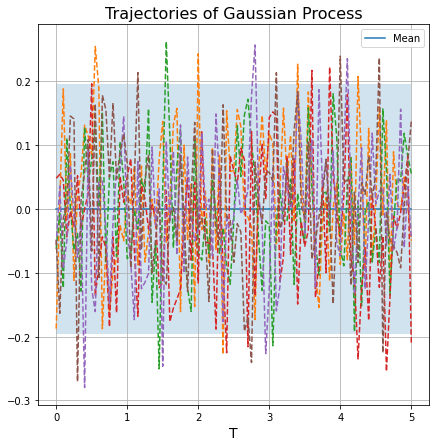

In [33]:
a=0
b=5
Nt=100
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)
PlotGaussianProcess(gpWhiteNoise,ts=ts)

Белый шум -- полезный процесс, потому что он часто используется в разных моделях, но всё-таки очень простой.

## Другие ковариационные функции

Как можно строить более сложные процессы? Очевидно, что основную сложность здесь представляет форма ковариационной функции, но их можно делать из более простых.

1. Сумма двух ковариационных функций $K_1+K_2$ тоже будет ковариационной функцией;
2. Если $K$ -- ковариационная функция, то $\alpha K$ для $\alpha \geq 0$ тоже ковариационная функция
3. Произведение двух ковариационных функций $K_1 \cdot K_2$ тоже будет ковариационной функцией (теорема Шура об Адамаровом произведении)

Весь этот инструментарий поддерживается в Gpy и sklearn.

Примеры ковариационных функций:
1. Ковариационная функция белого шума 
$$
K(t,s)= \begin{cases} &\sigma^2, &t=s,\\
&0,&t\neq s;
\end{cases}
$$
2. Линейная $K(t,s)=ts$;
3. Квадратично-экспоненциальная $K(t,s)= \exp\left(-\frac{(t-s)^2}{2l^2}\right)$;
4. Функция Орнштейна-Уленбека $K(t,s)= \exp\left(-\frac{(\vert t-s\vert }{2l^2}\right)$;
5. ...много других вы можете найти, например, в документации sklearn

In [57]:
# more examples
sqExpL=0.15
def mu0(t):
    return 0*np.ones(t.shape) 
def covSqExp(t,s):
    return np.exp(- (t[:,None]-s[None,:])**2/(2*sqExpL**2))

gpSqExp = GaussianProcess(mu0,covSqExp)

<AxesSubplot:title={'center':'Trajectories of Gaussian Process'}, xlabel='T'>

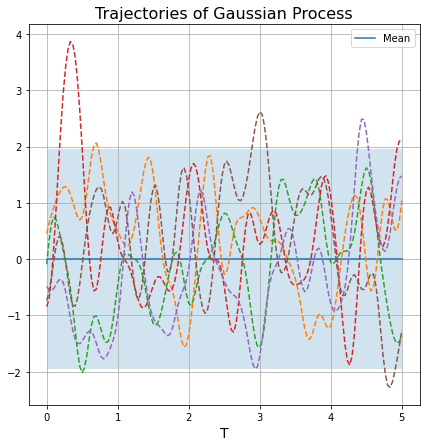

In [58]:
a=0
b=5
Nt=150
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)
PlotGaussianProcess(gpSqExp,ts=ts)

## Стационарность

Гауссовские процессы уникальны тем, что для них стационарность в узком смысле эквивалентна стационарности в широком смысле. Проверять часто проще второе.

Какие процессы выше будут стационарными (при $m(t)=0$)?...

Давайте попробуем сравнить стационарный и нестационарный процесс.

In [59]:
def covLin(t,s):
    return t[:,None]*s[None,:]
def covSq(t,s):
    return (t[:,None]*s[None,:])**2

gpLin = GaussianProcess(mu0,covLin)
gpSq = GaussianProcess(mu0,covSq)

<AxesSubplot:title={'center':'Square'}, xlabel='T'>

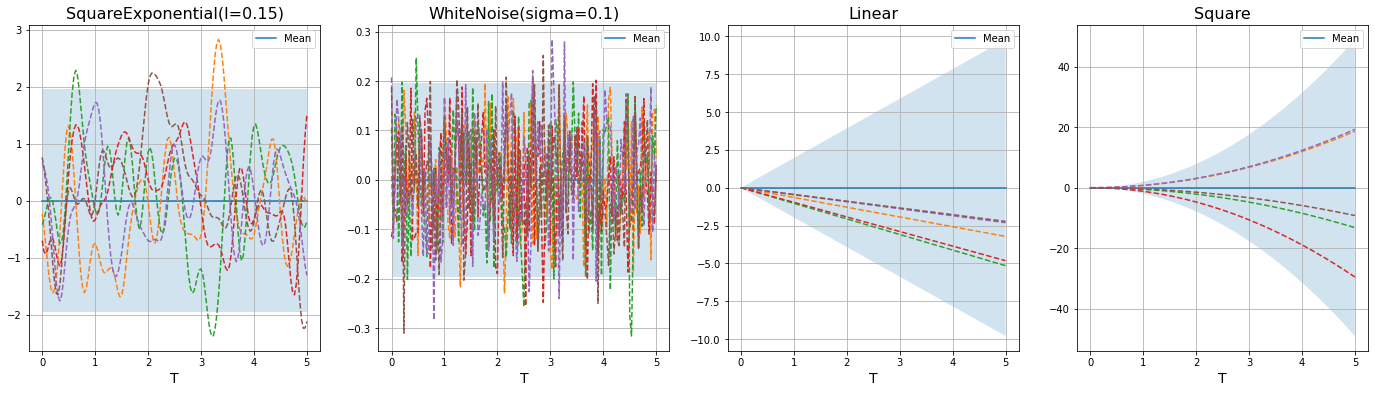

In [60]:
a=0
b=5
Nt=150
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(24,6))

PlotGaussianProcess(gpSqExp,ts=ts,title="SquareExponential(l="+str(sqExpL)+")",ax=ax1 )
PlotGaussianProcess(gpWhiteNoise,ts=ts,title="WhiteNoise(sigma="+str(sigma)+")",ax=ax2 )
PlotGaussianProcess(gpLin,ts=ts,title="Linear",ax=ax3 )
PlotGaussianProcess(gpSq,ts=ts,title="Square",ax=ax4 )

## Интерполяция и подгонка параметров (машинное обучение)

В обучении с учителем мы часто используем вероятностные модели $p_{\boldsymbol\theta}(\mathbf{Y} \lvert \mathbf{X})$ для объяснения данных. Для нахождения $\boldsymbol\theta$ самым популярным методом остаётся [Метод Максимального правдоподобия](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

Гауссовские процессы, таким образом, могут выступать как байесовская модель. Вначале нужно объявить некоторое простое априорное распределение для параметра $\boldsymbol\theta$. Затем мы используем данные, чтобы уточнить параметры. Такой подход работает как для регрессии, так и для классификации.

Вспомним, что гауссовский процесс -- это [случайный процесс](https://en.wikipedia.org/wiki/Stochastic_process), то есть, некоторое семейство случайных величин, проиндексированное  множеством $T$. Каждая точка $\mathbf{x} \in T$ переводится в случайную величину $f(\mathbf{x})$, причём совместное распределение любого конечного числа точек $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ гауссовское:

$$p(\mathbf{f} \lvert \mathbf{X}) = \mathcal{N}(\mathbf{f} \lvert \boldsymbol\mu, \mathbf{K}).\tag{1}$$

В уравнении $(1)$ $\mathbf{f} = (f(\mathbf{x}_1),...,f(\mathbf{x}_N))$, $\boldsymbol\mu = (m(\mathbf{x}_1),...,m(\mathbf{x}_N))$ и $K_{ij} = \kappa(\mathbf{x}_i,\mathbf{x}_j)$. Здесь $m$ -- функция среднего и типично(но не обязательно) полагать $m(\mathbf{x}) = 0$. Функция $\kappa$ задаёт ковариационную функцию. Таким образом, гауссовский процесс можно понимать как некоторое распределение на функциях, задаваемое ковариационной функцией $\mathbf{K}$ и функцией матожидания. 

Априорное распределение $p(\mathbf{f} \lvert \mathbf{X})$ можно использовать для вычисления апостериорного $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ имея данные $\mathbf{y}$. Апостериорное распределение можно использовать для предсказаний $\mathbf{f}_*$ при данных $\mathbf{X}_*$:

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) 
&= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\ 
&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{2}
\end{align*}
$$

Поскольку конечномерные распределения гауссовские, то вычислить апостериорное явно несложно: оно тоже будет гауссовским ([теорема о нормальной корреляции](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions)), как показывает уравнение $(2)$. Совместное распределение данных $\mathbf{y}$ и предсказаний  $\mathbf{f}_*$ записывается как

$$
\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)\tag{3}
$$

Если мы имеем $N$ элементов в данных для обучения и $N_*$ точек для предсказания, то $\mathbf{K}_y = \kappa(\mathbf{X},\mathbf{X}) + \sigma_y^2\mathbf{I} = \mathbf{K} + \sigma_y^2\mathbf{I}$ есть матрица $N \times N$, $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ -- это матрица $N \times N_*$ и $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$ будет размера $N_* \times N_*$. Параметр $\sigma_y^2$ в $\mathbf{K_y}$ описывает шум. Он задаётся нулём, если данные незашумлённые (редко, но бывает) и больше нуля в противном случае. Для простоты положим $\boldsymbol{0}$. Статистики $\boldsymbol{\mu}_*$ и $\boldsymbol{\Sigma}_*$, можно вычислить<sup>[1][3]</sup>

$$
\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y},\tag{4,5} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*.
\end{align*}
$$

Но и это ещё не всё! Поскольку мы смоделировали распределение вектора данных, мы можем с помощью метода максимального правдоподобия подогнать параметры: как параметры функции матожидания, так и параметры ковариационной функции. С использованием различных методов оптимизации. Поскольку это сюжет для других курсов, здесь мы его подробно не рассматриваем.

### Решение интерполяции и аппроксимации при фиксированных параметрах

Обе задачи в контексте гауссовских процессов решаются одинаково, однако в первом случае мы предполагаем, что шума в данных нет -- то есть, в точках данных $t_k$ нет никакой неопределённости насчёт значения $X_{t_k}$. Зато она есть в остальных точках.

Сначала предположим, что параметры модели фиксированы, а данные не зашумлены. Таким образом, нам нужно решить задачу интерполяции.

In [80]:
class GaussianProcessPredictive(GaussianProcess):

    #def __init__(self,mu,covFun):
    #    super(GaussianProcess, self).__init__(mu,covFun)
        
    def predict(self, ts, tsData, xData):
        '''
        Computes the suffifient statistics of the GP posterior predictive distribution 
        from m training data X_train and Y_train and n new inputs X_s.
    
        Input
            float[][] ts -- New input locations (n,d).
            tsData -- Given locations (m,d).
            xData -- Values at given locations (m,1).
    
        Returns:
            Posterior mean vector (n,d) and covariance matrix (n,n).
        '''

        K = self.covFun(tsData, tsData)
        Ks = self.covFun(tsData, ts)
        Kss = self.covFun(ts, ts)
        print(K.shape, Ks.shape, tsData.shape, ts.shape)
        Kinv = np.linalg.inv(K)#!!
    
        # Equation (4)
        muS = Ks.T.dot(Kinv).dot(xData)

        # Equation (5)
        covS = Kss - Ks.T.dot(Kinv).dot(Ks)
    
        return muS, covS

def PlotGaussianProcessPrediction(tsData,xsData, ts, musPred, covPred, nSamples=5, title="Interpolation with Gaussian Process", ax=None):
    '''
    Plots nSamples trajectories on a chart
    Input
    float[] tsData -- data indices (N,)
    float[] gpInstance -- GaussianProcess object to sample from
    int nSamples -- number of trajectories to generate
    float[] ts -- indices (N,)

    '''
    
    uncertainty = 1.96 * np.sqrt(np.diag(covPred))

    if(ax is None):
        f,ax = plt.subplots(figsize=(7,7))

    ax.grid()
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("T",fontsize=14)
    ax.fill_between(ts, musPred + uncertainty, musPred - uncertainty, alpha=0.2)
    ax.plot(ts, musPred, label='Mean')

    samples = np.random.multivariate_normal(musPred,covPred,size=nSamples)

    ax.plot(ts, samples.T, linestyle='--', linewidth=0.7) #transpose to satisfy matplotlib
    
    ax.scatter(tsData,xsData,marker="x", c="red", s=100)

    ax.legend()

    if(ax is None):
        return f,ax
    else:
        return ax

(5, 5) (5, 151) (5,) (151,)


<AxesSubplot:title={'center':'Interpolation with SqExp(l=0.15)'}, xlabel='T'>

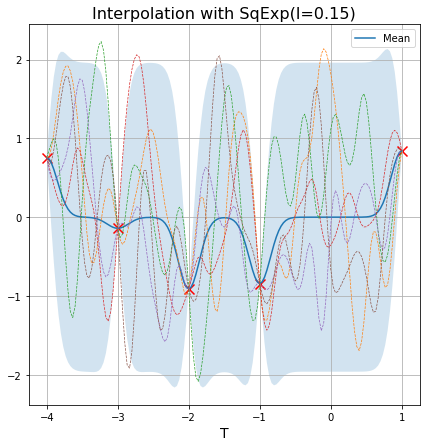

In [81]:
# Noise free training data
tsData = np.array([-4, -3, -2, -1, 1])
xsData = np.sin(tsData)

#new points
a=-4
b=1
Nt=150
h=(b-a)/Nt
ts=np.arange(a,b+h/2,h)

nSamples=5

# Compute mean and covariance of the posterior predictive distribution
gpSqExpPred = GaussianProcessPredictive(mu0,covSqExp)
muS, covS = gpSqExpPred.predict(ts, tsData, xsData)

PlotGaussianProcessPrediction(tsData,xsData, ts, musPred=muS, covPred=covS, nSamples=nSamples, title="Interpolation with SqExp(l="+str(sqExpL)+")")

Видно, что среднее решает задачу интерполяции по заданным точкам, но неопределённость очень большая. Это происходит из-за того, что параметры процесса фиксированны, их можно подогнать, чтобы уменьшить неопределённость. Мы не будем отдельно обсуждать этого вопроса, но вы можете подробнее узнать об этом в других ресурсах.

Зашумлённый случай требует лишь добавления белого шума.

(5, 5) (5, 151) (5,) (151,)


<AxesSubplot:title={'center':'Interpolation with SqExp(l=0.15) and WhNoise($\\sigma$=0.6)'}, xlabel='T'>

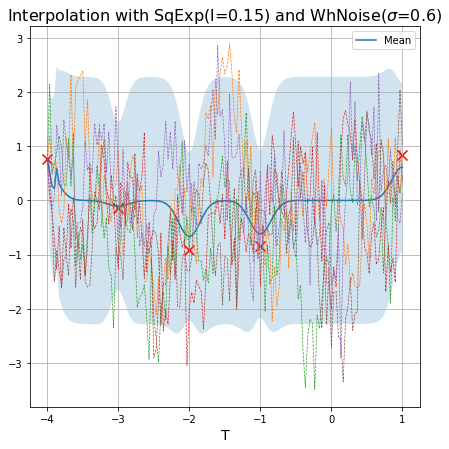

In [88]:
sqExpL=0.15
sigma=0.6
def mu0(t):
    return 0*np.ones(t.shape) 
def covSqExp(t,s):
    return np.exp(- (t[:,None]-s[None,:])**2/(2*sqExpL**2))

def covWhNoise(t,s):
    if t.shape[0]==s.shape[0]:
        return sigma**2 * np.diag(np.ones(t.shape))
    else:
        if(t.shape[0]<s.shape[0]):
            return np.concatenate( [sigma**2 * np.diag(np.ones(t.shape)), np.zeros([t.shape[0],s.shape[0]-t.shape[0]]) ], axis=1)
        else:
            return np.concatenate( [sigma**2 * np.diag(np.ones(t.shape)), np.zeros([t.shape[0]-s.shape[0],s.shape[0]]) ], axis=0)
    
def covFunSqExpWhNoise(t,s):
    return covSqExp(t,s)+covWhNoise(t,s)

gpSqExpWhNoisePred = GaussianProcessPredictive(mu0,covFunSqExpWhNoise)
muS, covS = gpSqExpWhNoisePred.predict(ts, tsData, xsData)

PlotGaussianProcessPrediction(tsData,xsData, ts, musPred=muS, covPred=covS, nSamples=nSamples, title=r"Interpolation with SqExp(l="+str(sqExpL)+") and WhNoise($\sigma$="+str(sigma)+")")

В завершение давайте попробуем посмотреть, как разные параметры влияют на модель.

(5, 5) (5, 151) (5,) (151,)
(5, 5) (5, 151) (5,) (151,)
(5, 5) (5, 151) (5,) (151,)
(5, 5) (5, 151) (5,) (151,)


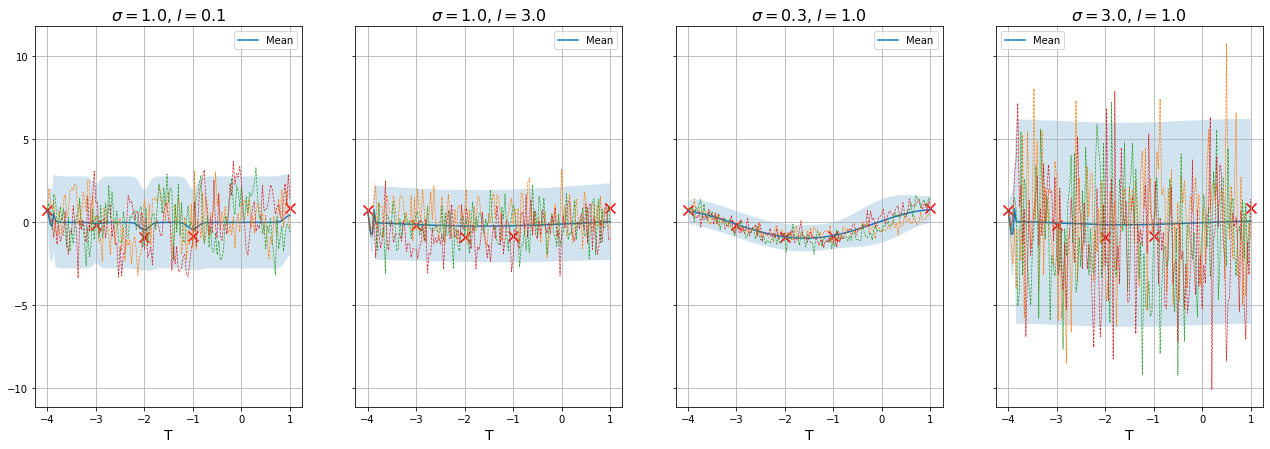

In [97]:
params = [
    (0.1, 1.0),
    (3.0, 1.0),
    (1.0, 0.3),
    (1.0, 3.0),
]

f, axs = plt.subplots(1, len(params),figsize=(22,7), sharey=True)

for i in np.arange(len(params)):

    sqExpL = params[i][0]
    sigma = params[i][1] 

    #re-init of GP
    def mu0(t):
        return 0*np.ones(t.shape) 
    def covSqExp(t,s):
        return np.exp(- (t[:,None]-s[None,:])**2/(2*sqExpL**2))

    def covWhNoise(t,s):
        if t.shape[0]==s.shape[0]:
            return sigma**2 * np.diag(np.ones(t.shape))
        else:
            if(t.shape[0]<s.shape[0]):
                return np.concatenate( [sigma**2 * np.diag(np.ones(t.shape)), np.zeros([t.shape[0],s.shape[0]-t.shape[0]]) ], axis=1)
            else:
                return np.concatenate( [sigma**2 * np.diag(np.ones(t.shape)), np.zeros([t.shape[0]-s.shape[0],s.shape[0]]) ], axis=0)
    
    def covFunSqExpWhNoise(t,s):
        return covSqExp(t,s)+covWhNoise(t,s)

    gpSqExpWhNoisePred = GaussianProcessPredictive(mu0,covFunSqExpWhNoise)
    ###


    muS, covS = gpSqExpWhNoisePred.predict(ts, tsData, xsData)
    PlotGaussianProcessPrediction(tsData, xsData, ts, musPred=muS, covPred=covS,nSamples=3,title=r"$\sigma="+str(sigma)+"$, $l="+ str(sqExpL)+"$", ax=axs[i])
    

    
    